This notebook is by Anastasia Ruzmaikina.

Here we analyse a dataset of nearly 5000 movies. The goal is to be able to predict if the movie is profitable given all the information available about the movie. The available data columns are the title, names of actors and actresses, movie genres, vote count, movie budget etc.

Using KNN method with 10 nearest neighbors, we can predict if a movie is profitable with accuracy 78%.

In [1]:
# Data manipulation
import numpy as np 
import pandas as pd

# Data Visualazation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import statsmodels.api as sm

import random
import scipy.optimize

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

We download the Movie Dataset from the Harvard Edx website.



In [2]:
df = pd.read_csv("https://courses.edx.org/asset-v1:HarvardX+PH526x+2T2019+type@asset+block@movie_data.csv", index_col=0)

df

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"Action, Crime, Thriller",NaN,9367,"united states–mexico barrier, legs, arms, pape...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,Columbia Pictures,...,2040920,81.0,Español,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,9367,"Carlos Gallardo, Jaime de Hoyos, Peter Marquar..."
4799,9000,"Comedy, Romance",NaN,72766,NaN,en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,NaN,...,0,85.0,NaN,Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,72766,"Edward Burns, Kerry Bishé, Marsha Dietlein, Ca..."
4800,0,"Comedy, Drama, Romance, TV Movie",http://www.hallmarkchannel.com/signedsealeddel...,231617,"date, love at first sight, narration, investig...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"Front Street Pictures, Muse Entertainment Ente...",...,0,120.0,English,Released,NaN,"Signed, Sealed, Delivered",7.0,6,231617,"Eric Mabius, Kristin Booth, Crystal Lowe, Geof..."
4801,0,NaN,http://shanghaicalling.com/,126186,NaN,en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,NaN,...,0,98.0,English,Released,A New Yorker in Shanghai,Shanghai Calling,5.7,7,126186,"Daniel Henney, Eliza Coupe, Bill Paxton, Alan ..."


We can look at the shape of the data set:

In [3]:
df.shape

(4803, 22)

We replace infinite values with NaN values in the data frame. NaN values are handled later.

In [4]:
df = df.replace(to_replace = np.inf, value = np.nan)
df = df.replace(to_replace = -np.inf, value = np.nan)

Next we do a one hot encoding of the 'genres' column.

First we identify how many different genres are present in the 'genres' column.

We split the genres into different columns. Each column contains 1's or 0's, one if that particlar genre is present in that row.



In [5]:
genr = []
for i in range(len(df['genres'])):
    temp = df['genres'].iloc[i]
    if not (isinstance(temp, float)):
       temp = temp.split(',')
       genr += temp
       
genre = list(set(genr))
for i in range(len(genre)):
    genre[i] = genre[i].strip()
genre = list(set(genre))
for item in genre:
    df[item] = df['budget']
for item in genre:
    for i in range(len(df['genres'])):
        if not (isinstance(df['genres'].iloc[i], float)):
             if item in df['genres'].iloc[i]:
                   df[item].iloc[i] = 1
             else:
                   df[item].iloc[i] = 0

We create a new column indicating if a movie is profitable.

The 'profitable' column is the difference between 'revenue' and 'budget' column.

In [6]:
df['profitable'] = df['revenue']
for i in range(len(df['revenue'])):
    if df['revenue'].iloc[i] >= df['budget'].iloc[i]:
        df['profitable'].iloc[i] = 1
    else:
        df['profitable'].iloc[i] = 0

In [7]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,Romance,Foreign,History,Fantasy,Music,Horror,Science Fiction,Thriller,Drama,profitable
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,0,0,0,1,0,0,1,0,0,1
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,0,0,0,1,0,0,0,0,0,1
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,0,0,0,0,0,0,0,0,0,1
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,0,0,0,0,0,0,0,1,1,1
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,0,0,0,0,0,0,1,0,0,1


Descriptive Statistics.

Before solving the problem, it's very important to have a good understanding of data.

First we get the descriptive statistics of the data.

Then we get the information about missing values in the data

In [8]:
# Info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4775 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4391 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4452 non-null   object 
 10  production_countries  4629 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4716 non-null   object 
 15  status               

In [9]:
# Summary statistic of the data
df.describe() 

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id,Action,Crime,...,Romance,Foreign,History,Fantasy,Music,Horror,Science Fiction,Thriller,Drama,profitable
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000,4803.000000,4.803000e+03,4.803000e+03,...,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989,57165.484281,7.705923e+02,7.704970e+02,...,7.705382e+02,7.703592e+02,7.703931e+02,7.704403e+02,7.703906e+02,7.704601e+02,7.704635e+02,7.706173e+02,7.708303e+02,0.723923
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891,88694.614033,3.441408e+04,3.441408e+04,...,3.441408e+04,3.441409e+04,3.441409e+04,3.441409e+04,3.441409e+04,3.441408e+04,3.441408e+04,3.441408e+04,3.441408e+04,0.447102
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,9014.500000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,14629.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000,58610.500000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000,2.000000e+06,2.000000e+06,...,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,1.000000


In [10]:
# Get count of missing values in every column
print(df.isna().sum())

budget                     0
genres                    28
homepage                3091
id                         0
keywords                 412
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies     351
production_countries     174
release_date               1
revenue                    0
runtime                    2
spoken_languages          87
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                      43
Action                     0
Crime                      0
Western                    0
War                        0
Animation                  0
Adventure                  0
TV Movie                   0
Comedy                     0
Family                     0
Mystery                    0
Documentary                0
Romance                    0
Foreign       

Conclusions:

The data contains some categorical columns, these columns need to be handled before building the model.

Some columns have missing values, these need to be handled before building the model. Since the columns with missing values are categorical, we are not going to have a problem with dropping them.

The y variable (profitable) doesn't have any missing values, which is good.

Now we list the numeric and categorical columns.



In [11]:
# Create list of numeric and categorical columns and check if they have extra spaces in the column names
num_col = df.select_dtypes(include=np.number).columns
print("Numerical columns: \n",num_col)

cat_col = df.select_dtypes(exclude=np.number).columns
print("Categorical columns: \n",cat_col)

Numerical columns: 
 Index(['budget', 'id', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'movie_id', 'Action', 'Crime', 'Western', 'War',
       'Animation', 'Adventure', 'TV Movie', 'Comedy', 'Family', 'Mystery',
       'Documentary', 'Romance', 'Foreign', 'History', 'Fantasy', 'Music',
       'Horror', 'Science Fiction', 'Thriller', 'Drama', 'profitable'],
      dtype='object')
Categorical columns: 
 Index(['genres', 'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'spoken_languages', 'status', 'tagline', 'title',
       'cast'],
      dtype='object')


We already did one hot encoding on the 'genres' column, so we can drop the 'genres' column.

The only categorical column that can influence the 'profitable' column is the 'cast' column. But if we do a one hot encoding, we find that we need a hundred or more columns. Therefore it is impractical to use 'cast' data and we are going to drop the 'cast' column.

All other categorical columns have very little influence on the revenue from the movie, so we can drop them.

In addition we are going to drop the 'revenue' column, because it is linearly dependent on the related 'profitable' column we are going to predict.

We are going to drop the columns 'id' and 'movie_id', because they carry no information.

In [12]:
df = df.drop(columns=['genres', 'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'spoken_languages', 'status', 'tagline', 'title',
       'cast', 'revenue', 'id', 'movie_id'])
df = df.dropna()
print(df.shape)

(4801, 26)


As a result of dropping categorical columns and the revenue column, only two rows remained with NaN values, when they were droppped the data frame has 4801 rows left.

In [13]:
df.head()

,budget,popularity,runtime,vote_average,vote_count,Action,Crime,Western,War,Animation,...,Romance,Foreign,History,Fantasy,Music,Horror,Science Fiction,Thriller,Drama,profitable
0,237000000,150.437577,162.0,7.2,11800,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,300000000,139.082615,169.0,6.9,4500,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,245000000,107.376788,148.0,6.3,4466,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,250000000,112.312950,165.0,7.6,9106,1,1,0,0,0,...,0,0,0,0,0,0,0,1,1,1
4,260000000,43.926995,132.0,6.1,2124,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


Check if the target variable 'profitable' is imbalanced


1    3477
0    1324
Name: profitable, dtype: int64


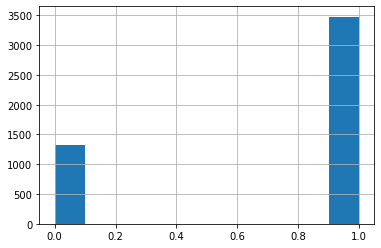

In [14]:
# view frequency distribution of values in `profitable` variable
print(df['profitable'].value_counts())
prf = df['profitable']
prf.hist()
plt.show()

Exploratory Data Analysis 

To check the distribution of variables, we plot the histograms to check variable distributions to find out if they are normal or skewed.

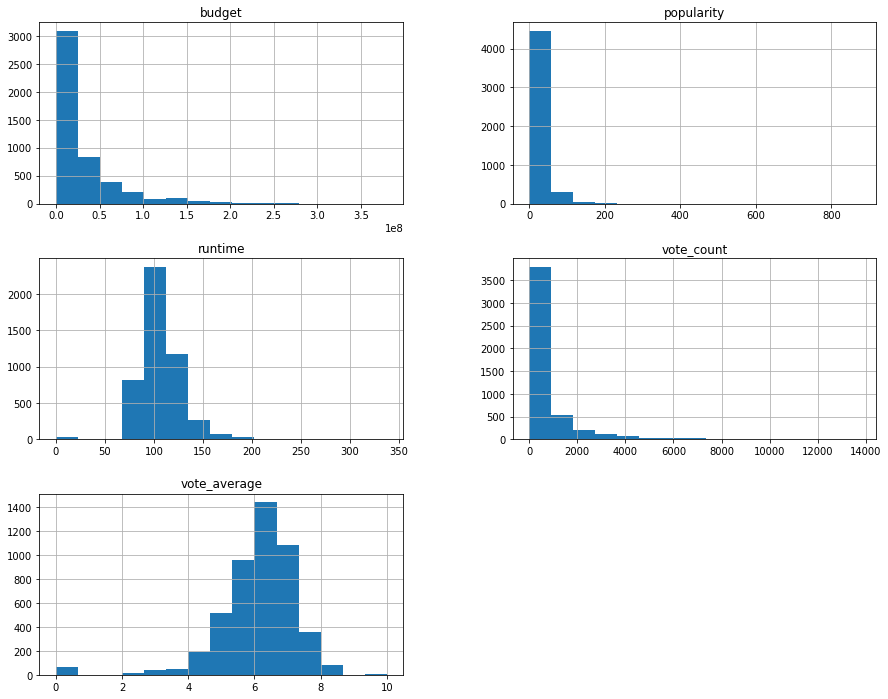

In [21]:
# plot histograms of the variables
params = df[['budget', 'popularity', 'runtime', 'vote_count', 'vote_average']]

params.hist(figsize=(15,12),bins = 15)

plt.show()

Data Preprocessing

In [22]:
# Split data in X and y dataset
X = df.drop(['profitable'], axis=1)
y = df['profitable']

In [23]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [24]:
# check the shape of X_train and X_test
X_train.shape, X_test.shape

((3840, 25), (961, 25))

In [25]:
# check data types in X_train
X_train.dtypes

budget               int64
popularity         float64
runtime            float64
vote_average       float64
vote_count           int64
Action               int64
Crime                int64
Western              int64
War                  int64
Animation            int64
Adventure            int64
TV Movie             int64
Comedy               int64
Family               int64
Mystery              int64
Documentary          int64
Romance              int64
Foreign              int64
History              int64
Fantasy              int64
Music                int64
Horror               int64
Science Fiction      int64
Thriller             int64
Drama                int64
dtype: object

Engineering missing values in variables

In [26]:
# check missing values in numerical variables in X_train
X_train.isnull().sum()

budget             0
popularity         0
runtime            0
vote_average       0
vote_count         0
Action             0
Crime              0
Western            0
War                0
Animation          0
Adventure          0
TV Movie           0
Comedy             0
Family             0
Mystery            0
Documentary        0
Romance            0
Foreign            0
History            0
Fantasy            0
Music              0
Horror             0
Science Fiction    0
Thriller           0
Drama              0
dtype: int64

There are no missing values

We now have training and testing set ready for model building. Before that, we should map all the feature variables onto the same scale. It is called feature scaling.

In [27]:
cols = X_train.columns

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [30]:
X_train.head()

,budget,popularity,runtime,vote_average,vote_count,Action,Crime,Western,War,Animation,...,Documentary,Romance,Foreign,History,Fantasy,Music,Horror,Science Fiction,Thriller,Drama
0,-0.690757,-0.652988,-0.787175,-0.499753,-0.543529,-0.025019,-0.025043,-0.025013,-0.02504,-0.025040,...,-0.02504,-0.025018,-0.025039,-0.02504,-0.025041,-0.025014,-0.025042,-0.025042,-0.025046,-0.025025
1,0.320615,0.384224,-0.743301,-0.249529,0.065393,-0.025045,-0.025043,-0.025039,-0.02504,-0.025040,...,-0.02504,-0.025018,-0.025039,-0.02504,-0.025041,-0.025040,-0.025042,-0.025042,-0.025046,-0.025051
2,-0.709875,-0.666992,-0.392302,0.751368,-0.529764,-0.025045,-0.025043,-0.025039,-0.02504,-0.025040,...,-0.02504,-0.025044,-0.025039,-0.02504,-0.025041,-0.025040,-0.025042,-0.025042,-0.025046,-0.025025
3,4.218101,2.209411,-0.129054,0.751368,2.296215,-0.025045,-0.025043,-0.025039,-0.02504,-0.025014,...,-0.02504,-0.025044,-0.025039,-0.02504,-0.025041,-0.025040,-0.025042,-0.025042,-0.025046,-0.025051
4,-0.715425,-0.699994,-1.006549,-5.087196,-0.560533,-0.025045,-0.025043,-0.025039,-0.02504,-0.025040,...,-0.02504,-0.025044,-0.025039,-0.02504,-0.025041,-0.025040,-0.025042,-0.025042,-0.025020,-0.025025


Model Building 

Parameters

n_neighbors:int, default=5 Number of neighbors to use by default for kneighbors queries.
weights:{‘uniform’, ‘distance’} or callable, default=’uniform’ weight function used in prediction. Possible values:
‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.

‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

algorithm:{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’ Algorithm used to compute the nearest neighbors:
‘ball_tree’ will use BallTree

‘kd_tree’ will use KDTree

‘brute’ will use a brute-force search.

‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.



In [31]:
# import KNeighbors ClaSSifier from sklearn
from sklearn.neighbors import KNeighborsClassifier


# instantiate the model
knn = KNeighborsClassifier(n_neighbors=2, weights="distance")


# fit the model to the training set
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=2, weights='distance')

Predict test-set results 


In [32]:
# Predicting the test values
y_pred = knn.predict(X_test)

y_pred[0:50]

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1])

predict_proba method

predict_proba method gives the probabilities for the target variable 'profitable' to take value 0 or 1.

In [33]:
# probability of getting y = 0
knn.predict_proba(X_test)[:,0]

array([0.        , 1.        , 0.        , 1.        , 1.        ,
       0.47138168, 1.        , 0.48804255, 0.        , 0.49325139,
       0.        , 1.        , 0.50305115, 0.        , 0.        ,
       0.42828914, 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.4516112 , 1.        ,
       0.        , 0.        , 0.54074437, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.49727123, 1.        ,
       0.        , 0.50762249, 0.        , 0.        , 0.        ,
       0.        , 0.55419267, 0.        , 0.38873923, 0.        ,
       0.        , 1.        , 1.        , 0.        , 0.32272572,
       0.52219374, 1.        , 0.        , 0.        , 0.        ,
       0.36718334, 0.        , 0.54280441, 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.42813149, 0.        , 0.        ,
       0.        , 0.41891859, 0.        , 0.43293331, 0.     

In [34]:
# probability of getting y = 1
knn.predict_proba(X_test)[:,1]

array([1.        , 0.        , 1.        , 0.        , 0.        ,
       0.52861832, 0.        , 0.51195745, 1.        , 0.50674861,
       1.        , 0.        , 0.49694885, 1.        , 1.        ,
       0.57171086, 1.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.5483888 , 0.        ,
       1.        , 1.        , 0.45925563, 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.50272877, 0.        ,
       1.        , 0.49237751, 1.        , 1.        , 1.        ,
       1.        , 0.44580733, 1.        , 0.61126077, 1.        ,
       1.        , 0.        , 0.        , 1.        , 0.67727428,
       0.47780626, 0.        , 1.        , 1.        , 1.        ,
       0.63281666, 1.        , 0.45719559, 1.        , 1.        ,
       1.        , 0.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.57186851, 1.        , 1.        ,
       1.        , 0.58108141, 1.        , 0.56706669, 1.     

Check accuracy score 

In [35]:
from sklearn.metrics import accuracy_score
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.7253


In [36]:
from   sklearn.metrics import confusion_matrix , classification_report

# Evaluate the model
def compute_evaluation_metric(y_actual, y_predicted):
    print("\n Accuracy Score : ",accuracy_score(y_actual,y_predicted))
    print("\n Confusion Matrix : \n",confusion_matrix(y_actual, y_predicted))
    print("\n Classification Report : \n",classification_report(y_actual, y_predicted))

In [37]:
compute_evaluation_metric(y_test, y_pred)


 Accuracy Score :  0.7252861602497399

 Confusion Matrix : 
 [[129 140]
 [124 568]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.51      0.48      0.49       269
           1       0.80      0.82      0.81       692

    accuracy                           0.73       961
   macro avg       0.66      0.65      0.65       961
weighted avg       0.72      0.73      0.72       961



Here, y_test are the true class labels and y_pred are the predicted class labels in the test-set.

Rebuild kNN Classification model using different values of k 

We have build the kNN classification model using k=2. Now, we shall increase the value of k and see its effect on accuracy.



Rebuild kNN Classification model using k=5


In [38]:
# instantiate the model with k=5
knn_5 = KNeighborsClassifier(n_neighbors=5, weights="distance")


# fit the model to the training set
knn_5.fit(X_train, y_train)


# predict on the test-set
y_pred_5 = knn_5.predict(X_test)


print('Model accuracy score with k=5 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_5)))

Model accuracy score with k=5 : 0.7659


In [39]:
compute_evaluation_metric(y_test, y_pred_5)


 Accuracy Score :  0.7658688865764828

 Confusion Matrix : 
 [[116 153]
 [ 72 620]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.62      0.43      0.51       269
           1       0.80      0.90      0.85       692

    accuracy                           0.77       961
   macro avg       0.71      0.66      0.68       961
weighted avg       0.75      0.77      0.75       961



Rebuild kNN Classification model using k=10

In [40]:
# instantiate the model with k=10

%time
knn_10 = KNeighborsClassifier(n_neighbors=10, weights="distance")


# fit the model to the training set
knn_10.fit(X_train, y_train)


# predict on the test-set
y_pred_10 = knn_10.predict(X_test)


print('Model accuracy score with k=10 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_10)))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
Model accuracy score with k=10 : 0.7804


In [41]:
compute_evaluation_metric(y_test, y_pred_10)


 Accuracy Score :  0.7804370447450573

 Confusion Matrix : 
 [[110 159]
 [ 52 640]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.68      0.41      0.51       269
           1       0.80      0.92      0.86       692

    accuracy                           0.78       961
   macro avg       0.74      0.67      0.68       961
weighted avg       0.77      0.78      0.76       961



Rebuild kNN Classification model using algorithm = 'kd_tree'


KDTree for fast generalized N-point problems. kd_tree is a faster version of traditional knn algorithm.



In [42]:
# instantiate the model with k=10
%time
knn_10 = KNeighborsClassifier(n_neighbors=10, weights="distance", algorithm = 'kd_tree')


# fit the model to the training set
knn_10.fit(X_train, y_train)


# predict on the test-set
y_pred_10 = knn_10.predict(X_test)


print('Model accuracy score with k=10 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_10)))

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.77 µs
Model accuracy score with k=10 : 0.7804


In [43]:
compute_evaluation_metric(y_test, y_pred_10)


 Accuracy Score :  0.7804370447450573

 Confusion Matrix : 
 [[110 159]
 [ 52 640]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.68      0.41      0.51       269
           1       0.80      0.92      0.86       692

    accuracy                           0.78       961
   macro avg       0.74      0.67      0.68       961
weighted avg       0.77      0.78      0.76       961



Rebuild kNN Classification model using k=15


In [44]:
# instantiate the model with k=15
knn_15 = KNeighborsClassifier(n_neighbors=15, weights ="distance")


# fit the model to the training set
knn_15.fit(X_train, y_train)


# predict on the test-set
y_pred_15 = knn_15.predict(X_test)


print('Model accuracy score with k=15 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_15)))

Model accuracy score with k=15 : 0.7804


In [45]:
compute_evaluation_metric(y_test, y_pred_15)


 Accuracy Score :  0.7804370447450573

 Confusion Matrix : 
 [[104 165]
 [ 46 646]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.69      0.39      0.50       269
           1       0.80      0.93      0.86       692

    accuracy                           0.78       961
   macro avg       0.74      0.66      0.68       961
weighted avg       0.77      0.78      0.76       961



Interpretation

Our original model accuracy score with k=2 is 0.7253. Now we got accuracy score of 0.7659 with k=5. But, if we increase the value of k further, this would result in enhanced accuracy.

With k=10,15 we get accuracy score of 0.7804. So, it results in performance improvement.

Now, based on the above analysis we can conclude that our classification model accuracy is good. Our model is doing a good job in terms of predicting if a movie is profitable.



Elbow Method for Choosing Reasonable K Values

NOTE: This uses the test set for the hyperparameter selection of K.



In [46]:
test_error_rates = []


for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train) 
   
    y_pred_test = knn_model.predict(X_test)
    
    test_error = 1 - accuracy_score(y_test,y_pred_test)
    test_error_rates.append(test_error)

Text(0.5, 0, 'K Value')

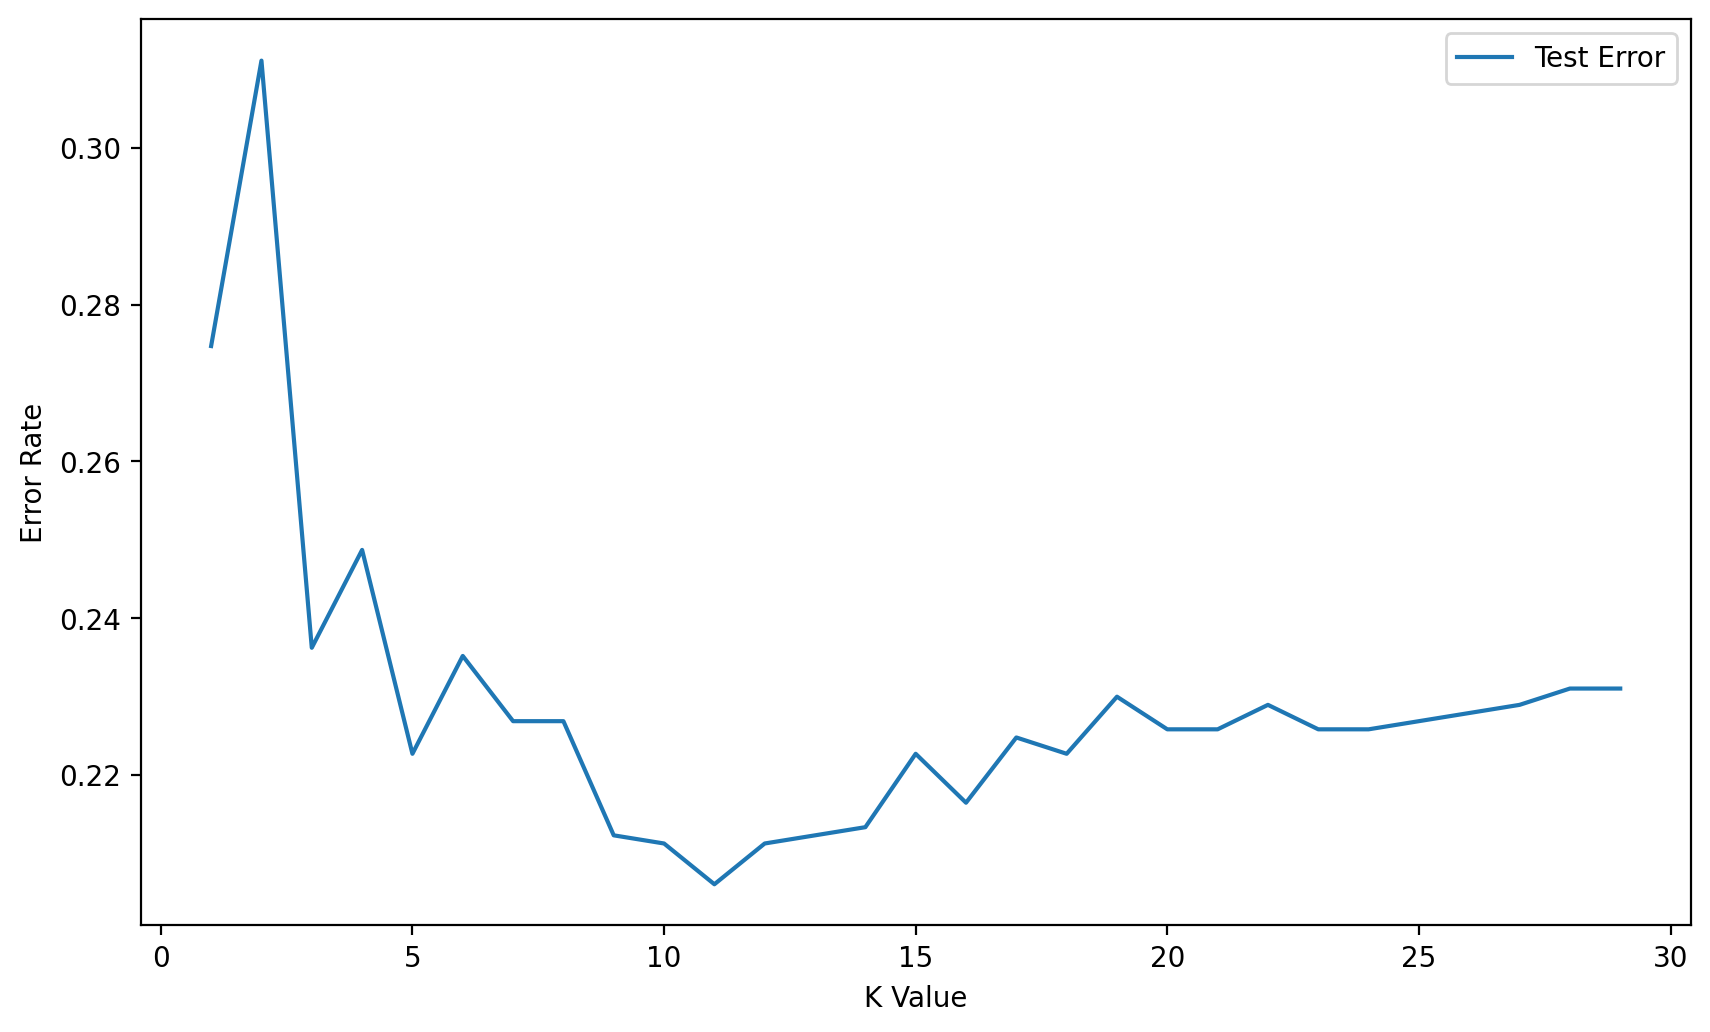

In [47]:
plt.figure(figsize=(10,6),dpi=200)
plt.plot(range(1,30),test_error_rates,label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("K Value")

Hyperparameter Tuning Using GridSearchCV


It will cross validate the score as well

n_neighbors:int, default=5 Number of neighbors to use by default for kneighbors queries.

weights:{‘uniform’, ‘distance’} or callable, default=’uniform’ weight function used in prediction. 
Possible values:
‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.

‘distance’ : weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

In [48]:
# Importing GridsearchCV
from sklearn.model_selection import GridSearchCV

In [49]:
# Assigning all the parameters of Decision tree classifier for  parameters variable
parameters ={
    'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,35,36,37,38,39,40,41,42,43,44,45,50,55,60],
    'weights':['uniform','distance'],
}
grid_search = KNeighborsClassifier()


In [50]:
# Assigning parameters for GridSearchCV
grid_search = GridSearchCV(grid_search,parameters, scoring='accuracy', verbose=2, cv=5)

In [51]:
# Fitting the model into gridsearchCV
grid_result= grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 78 candidates, totalling 390 fits
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=3, we

[CV] END ....................n_neighbors=12, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=12, weights=uniform; total time=   0.1s
[CV] END ...................n_neighbors=12, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=12, weights=distance; total time=   0.0s
[CV] END ...................n_neighbors=12, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=12, weights=distance; total time=   0.0s
[CV] END ...................n_neighbors=12, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=13, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=13, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=13, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=13, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=13, weights=uniform; total time=   0.1s
[CV] END ...................

[CV] END ...................n_neighbors=22, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=22, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=22, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=22, weights=distance; total time=   0.1s
[CV] END ....................n_neighbors=23, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=23, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=23, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=23, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=23, weights=uniform; total time=   0.1s
[CV] END ...................n_neighbors=23, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=23, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=23, weights=distance; total time=   0.1s
[CV] END ...................

[CV] END ...................n_neighbors=40, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=40, weights=distance; total time=   0.1s
[CV] END ....................n_neighbors=41, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=41, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=41, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=41, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=41, weights=uniform; total time=   0.1s
[CV] END ...................n_neighbors=41, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=41, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=41, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=41, weights=distance; total time=   0.1s
[CV] END ...................n_neighbors=41, weights=distance; total time=   0.1s
[CV] END ...................

best_index_: (int) The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.

In [52]:
print('Best index: ', grid_result.best_index_)

Best index:  60


best_params (dict): Parameter setting that gave the best results on the hold out data.



In [53]:
print('Best Params: ', grid_result.best_params_)

Best Params:  {'n_neighbors': 40, 'weights': 'uniform'}


best_score (float) : Mean cross-validated score of the best_estimator

For multi-metric evaluation, this is present only if refit is specified.

This attribute is not available if refit is a function.

In [54]:
print('Best Score: ', grid_result.best_score_)

Best Score:  0.7802083333333333


Conclusion: using KNN method with 10 nearest neighbors, we can predict if a movie is profitable with accuracy 78%.